In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True

In [3]:
# 학습을 위해 데이터 증가(augmentation) 및 일반화(normalization)
# 검증을 위한 일반화
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# 데이터셋 위치
data_dir1 = '../../pretrained_GNN/dataset/fruit_fresh_and_rotten_dataset'
data_dir2 = '../../pretrained_GNN/dataset/fruit_quality'
data_dir3 = '../../pretrained_GNN/dataset/fruit_quality2'

# 데이터셋 정제
image_datasets1 = {x: datasets.ImageFolder(os.path.join(data_dir1, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
image_datasets2 = {x: datasets.ImageFolder(os.path.join(data_dir2, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
image_datasets3 = {x: datasets.ImageFolder(os.path.join(data_dir3, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

dataloaders1 = {x: torch.utils.data.DataLoader(image_datasets1[x], batch_size=64,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val']}
dataloaders2 = {x: torch.utils.data.DataLoader(image_datasets2[x], batch_size=64,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val']}
dataloaders3 = {x: torch.utils.data.DataLoader(image_datasets3[x], batch_size=64,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val']}


dataset_sizes1 = {x: len(image_datasets1[x]) for x in ['train', 'val']}
dataset_sizes2 = {x: len(image_datasets2[x]) for x in ['train', 'val']}
dataset_sizes2 = {x: len(image_datasets2[x]) for x in ['train', 'val']}


class_names1 = image_datasets1['train'].classes
class_names2 = image_datasets2['train'].classes
class_names3 = image_datasets3['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [9]:
print(len(class_names1), len(class_names2), len(class_names3))

6 12 2


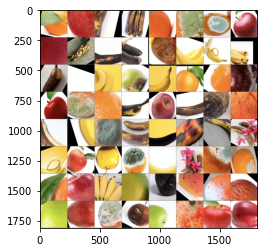

['freshoranges', 'freshapples', 'rottenbanana', 'rottenbanana', 'freshoranges', 'rottenoranges', 'rottenoranges', 'freshapples', 'freshapples', 'rottenbanana', 'rottenbanana', 'rottenbanana', 'rottenapples', 'freshbanana', 'freshbanana', 'freshbanana', 'rottenbanana', 'freshbanana', 'freshbanana', 'rottenapples', 'freshbanana', 'freshoranges', 'freshoranges', 'rottenapples', 'freshapples', 'rottenoranges', 'freshoranges', 'rottenbanana', 'freshapples', 'rottenbanana', 'rottenapples', 'rottenapples', 'rottenbanana', 'freshbanana', 'rottenoranges', 'rottenbanana', 'rottenbanana', 'rottenbanana', 'rottenbanana', 'rottenbanana', 'freshbanana', 'freshapples', 'rottenapples', 'rottenoranges', 'freshbanana', 'rottenbanana', 'rottenoranges', 'rottenoranges', 'freshoranges', 'freshapples', 'freshbanana', 'freshoranges', 'rottenapples', 'rottenapples', 'rottenoranges', 'rottenapples', 'freshapples', 'freshapples', 'rottenoranges', 'rottenapples', 'freshapples', 'rottenoranges', 'freshapples', 'f

In [10]:
# transform 된 배치 이미지 시각화
def imshow1(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # 갱신이 될 때까지 잠시 기다립니다.


# 학습 데이터의 배치를 얻습니다.
inputs, classes = next(iter(dataloaders1['train']))

# 배치로부터 격자 형태의 이미지를 만듭니다.
out = torchvision.utils.make_grid(inputs)

imshow1(out)
print([class_names1[x] for x in classes])

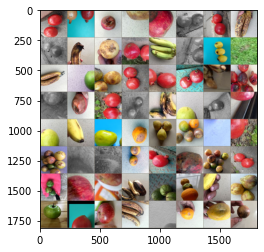

['Pomegranate_Good', 'Pomegranate_Good', 'Apple_Bad', 'Guava_Bad', 'Apple_Bad', 'Pomegranate_Good', 'Pomegranate_Good', 'Banana_Bad', 'Pomegranate_Good', 'Banana_Bad', 'Guava_Bad', 'Pomegranate_Good', 'Banana_Good', 'Pomegranate_Good', 'Guava_Good', 'Pomegranate_Good', 'Banana_Bad', 'Lime_Good', 'Guava_Bad', 'Pomegranate_Good', 'Pomegranate_Good', 'Pomegranate_Good', 'Banana_Bad', 'Pomegranate_Bad', 'Pomegranate_Good', 'Apple_Bad', 'Pomegranate_Good', 'Pomegranate_Good', 'Banana_Bad', 'Lime_Good', 'Pomegranate_Good', 'Apple_Good', 'Lime_Good', 'Banana_Good', 'Guava_Good', 'Orange_Bad', 'Guava_Good', 'Orange_Bad', 'Orange_Good', 'Pomegranate_Good', 'Lime_Bad', 'Pomegranate_Good', 'Pomegranate_Good', 'Lime_Bad', 'Pomegranate_Good', 'Pomegranate_Bad', 'Lime_Bad', 'Pomegranate_Good', 'Guava_Good', 'Apple_Bad', 'Apple_Good', 'Banana_Bad', 'Guava_Good', 'Orange_Good', 'Banana_Good', 'Guava_Bad', 'Apple_Good', 'Pomegranate_Good', 'Apple_Good', 'Banana_Bad', 'Pomegranate_Good', 'Orange_Bad', '

In [11]:
# transform 된 배치 이미지 시각화
def imshow2(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # 갱신이 될 때까지 잠시 기다립니다.


# 학습 데이터의 배치를 얻습니다.
inputs, classes = next(iter(dataloaders2['train']))

# 배치로부터 격자 형태의 이미지를 만듭니다.
out = torchvision.utils.make_grid(inputs)

imshow2(out)
print([class_names2[x] for x in classes])

In [ ]:
# transform 된 배치 이미지 시각화
def imshow3(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # 갱신이 될 때까지 잠시 기다립니다.


# 학습 데이터의 배치를 얻습니다.
inputs, classes = next(iter(dataloaders3['train']))

# 배치로부터 격자 형태의 이미지를 만듭니다.
out = torchvision.utils.make_grid(inputs)

imshow1(out)
print([class_names3[x] for x in classes])

In [14]:
# # 미리 학습된 resnet 모델 불러오기
# model_ft = models.resnet18(pretrained = True)
# model_ft = model_ft.to(device)

# print(model_ft)
# 1/0
# # 마지막 연결계층의 입력부분까지 받아오기 > 완전계층 이후 부분은 학습
# num_ftrs = model_ft.fc.in_features
# # 여기서 각 출력 샘플의 크기는 2로 설정합니다.
# # 또는, nn.Linear(num_ftrs, len (class_names))로 일반화할 수 있습니다.
# model_ft.fc = nn.Linear(num_ftrs, len (class_names1))
# model_ft.fc = model_ft.fc.to(device)

# criterion = nn.CrossEntropyLoss()

# # 모든 매개변수들이 최적화되었는지 관찰
# optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# # 7 에폭마다 0.1씩 학습률 감소
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

ZeroDivisionError: division by zero

In [27]:
# 미리 학습된 resnet 모델 불러오기
model_ft = models.alexnet(pretrained = True)
model_ft = model_ft.to(device)

# print(model_ft)
# 1/0
# 마지막 연결계층의 입력부분까지 받아오기 > 완전계층 이후 부분은 학습
# num_ftrs = model_ft.classifier[6].in_features
model_ft.classifier[4] = nn.Linear(4096, 9216)
# 여기서 각 출력 샘플의 크기는 2로 설정합니다.
# 또는, nn.Linear(num_ftrs, len (class_names))로 일반화할 수 있습니다.
model_ft.classifier[6] = nn.Linear(9216, len (class_names1))
model_ft.classifier = model_ft.classifier.to(device)

print(model_ft)
# 1/0
criterion = nn.CrossEntropyLoss()

# 모든 매개변수들이 최적화되었는지 관찰
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# 7 에폭마다 0.1씩 학습률 감소
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [28]:
from torchsummary import summary

summary(model_ft, (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

In [29]:
from tqdm import tqdm

def train_model1(model, criterion, optimizer, scheduler, num_epochs=25):
    model = model.to(device)
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())      # 모델 학습파라미터 불러와서 카피
    best_acc = 0.0

    for epoch in tqdm(range(num_epochs)):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # 각 에폭(epoch)은 학습 단계와 검증 단계를 갖습니다.
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # 모델을 학습 모드로 설정
            else:
                model.eval()   # 모델을 평가 모드로 설정

            running_loss = 0.0
            running_corrects = 0

            # 데이터를 배치크기로 반복해서 불러옴
            for inputs, labels in dataloaders1[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 매개변수 경사도를 0으로 설정
                optimizer.zero_grad()

                # 순전파
                # 학습 시에만 연산 기록을 추적
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # 학습 단계인 경우 역전파 + 최적화
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 통계
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes1[phase]
            epoch_acc = running_corrects.double() / dataset_sizes1[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # 모델을 깊은 복사(deep copy)함, 값 갱신
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()
        time.sleep(0.1)

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # 가장 나은 모델 가중치를 불러옴
    model.load_state_dict(best_model_wts)
    return model

In [30]:
train_model1(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=20)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0/19
----------
train Loss: 0.3278 Acc: 0.8842


  5%|▌         | 1/20 [00:26<08:30, 26.87s/it]

val Loss: 0.0814 Acc: 0.9718

Epoch 1/19
----------
train Loss: 0.1501 Acc: 0.9475


 10%|█         | 2/20 [00:53<08:02, 26.80s/it]

val Loss: 0.0899 Acc: 0.9703

Epoch 2/19
----------
train Loss: 0.1183 Acc: 0.9584


 15%|█▌        | 3/20 [01:20<07:34, 26.76s/it]

val Loss: 0.0304 Acc: 0.9893

Epoch 3/19
----------
train Loss: 0.1114 Acc: 0.9614


 20%|██        | 4/20 [01:47<07:08, 26.76s/it]

val Loss: 0.0165 Acc: 0.9959

Epoch 4/19
----------
train Loss: 0.0907 Acc: 0.9681


 25%|██▌       | 5/20 [02:13<06:39, 26.67s/it]

val Loss: 0.0272 Acc: 0.9889

Epoch 5/19
----------
train Loss: 0.0873 Acc: 0.9718


 30%|███       | 6/20 [02:40<06:13, 26.65s/it]

val Loss: 0.0112 Acc: 0.9970

Epoch 6/19
----------
train Loss: 0.0788 Acc: 0.9734


 35%|███▌      | 7/20 [03:06<05:46, 26.66s/it]

val Loss: 0.0163 Acc: 0.9952

Epoch 7/19
----------
train Loss: 0.0597 Acc: 0.9789


 40%|████      | 8/20 [03:33<05:20, 26.68s/it]

val Loss: 0.0078 Acc: 0.9970

Epoch 8/19
----------
train Loss: 0.0560 Acc: 0.9814


 45%|████▌     | 9/20 [04:00<04:54, 26.80s/it]

val Loss: 0.0069 Acc: 0.9974

Epoch 9/19
----------
train Loss: 0.0513 Acc: 0.9812


 50%|█████     | 10/20 [04:27<04:28, 26.84s/it]

val Loss: 0.0060 Acc: 0.9978

Epoch 10/19
----------
train Loss: 0.0501 Acc: 0.9833


 55%|█████▌    | 11/20 [04:54<04:00, 26.76s/it]

val Loss: 0.0068 Acc: 0.9974

Epoch 11/19
----------
train Loss: 0.0539 Acc: 0.9814


 60%|██████    | 12/20 [05:20<03:33, 26.74s/it]

val Loss: 0.0069 Acc: 0.9974

Epoch 12/19
----------
train Loss: 0.0537 Acc: 0.9808


 65%|██████▌   | 13/20 [05:47<03:06, 26.66s/it]

val Loss: 0.0056 Acc: 0.9981

Epoch 13/19
----------
train Loss: 0.0492 Acc: 0.9837


 70%|███████   | 14/20 [06:14<02:40, 26.67s/it]

val Loss: 0.0036 Acc: 0.9985

Epoch 14/19
----------
train Loss: 0.0449 Acc: 0.9854


 75%|███████▌  | 15/20 [06:40<02:13, 26.71s/it]

val Loss: 0.0042 Acc: 0.9985

Epoch 15/19
----------
train Loss: 0.0516 Acc: 0.9818


 80%|████████  | 16/20 [07:07<01:47, 26.80s/it]

val Loss: 0.0044 Acc: 0.9985

Epoch 16/19
----------
train Loss: 0.0489 Acc: 0.9825


 85%|████████▌ | 17/20 [07:34<01:20, 26.73s/it]

val Loss: 0.0045 Acc: 0.9985

Epoch 17/19
----------
train Loss: 0.0458 Acc: 0.9841


 90%|█████████ | 18/20 [08:00<00:53, 26.67s/it]

val Loss: 0.0049 Acc: 0.9985

Epoch 18/19
----------
train Loss: 0.0505 Acc: 0.9837


 95%|█████████▌| 19/20 [08:27<00:26, 26.66s/it]

val Loss: 0.0043 Acc: 0.9985

Epoch 19/19
----------
train Loss: 0.0517 Acc: 0.9803


100%|██████████| 20/20 [08:54<00:00, 26.71s/it]

val Loss: 0.0043 Acc: 0.9985

Training complete in 8m 54s
Best val Acc: 0.998517


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [31]:
model_ft = models.alexnet(pretrained = True)
model_ft = model_ft.to(device)

# print(model_ft)
# 1/0
# 마지막 연결계층의 입력부분까지 받아오기 > 완전계층 이후 부분은 학습
# num_ftrs = model_ft.classifier[6].in_features
model_ft.classifier[4] = nn.Linear(4096, 9216)
# 여기서 각 출력 샘플의 크기는 2로 설정합니다.
# 또는, nn.Linear(num_ftrs, len (class_names))로 일반화할 수 있습니다.
model_ft.classifier[6] = nn.Linear(9216, len (class_names2))
model_ft.classifier = model_ft.classifier.to(device)

print(model_ft)
# 1/0
criterion = nn.CrossEntropyLoss()

# 모든 매개변수들이 최적화되었는지 관찰
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# 7 에폭마다 0.1씩 학습률 감소
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [32]:
summary(model_ft, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

In [33]:
from tqdm import tqdm

def train_model2(model, criterion, optimizer, scheduler, num_epochs=25):
    model = model.to(device)
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())      # 모델 학습파라미터 불러와서 카피
    best_acc = 0.0

    for epoch in tqdm(range(num_epochs)):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # 각 에폭(epoch)은 학습 단계와 검증 단계를 갖습니다.
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # 모델을 학습 모드로 설정
            else:
                model.eval()   # 모델을 평가 모드로 설정

            running_loss = 0.0
            running_corrects = 0

            # 데이터를 배치크기로 반복해서 불러옴
            for inputs, labels in dataloaders2[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 매개변수 경사도를 0으로 설정
                optimizer.zero_grad()

                # 순전파
                # 학습 시에만 연산 기록을 추적
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # 학습 단계인 경우 역전파 + 최적화
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 통계
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes2[phase]
            epoch_acc = running_corrects.double() / dataset_sizes2[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # 모델을 깊은 복사(deep copy)함, 값 갱신
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()
        time.sleep(0.1)

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # 가장 나은 모델 가중치를 불러옴
    model.load_state_dict(best_model_wts)
    return model

In [34]:
train_model2(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=20)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0/19
----------
train Loss: 0.5073 Acc: 0.8360


  5%|▌         | 1/20 [01:47<33:53, 107.05s/it]

val Loss: 0.5281 Acc: 0.8378

Epoch 1/19
----------
train Loss: 0.2304 Acc: 0.9246


 10%|█         | 2/20 [03:37<32:44, 109.13s/it]

val Loss: 0.3869 Acc: 0.8709

Epoch 2/19
----------
train Loss: 0.1781 Acc: 0.9410


 15%|█▌        | 3/20 [05:28<31:06, 109.78s/it]

val Loss: 0.3562 Acc: 0.8825

Epoch 3/19
----------
train Loss: 0.1652 Acc: 0.9444


 20%|██        | 4/20 [07:14<28:52, 108.31s/it]

val Loss: 0.3620 Acc: 0.8912

Epoch 4/19
----------
train Loss: 0.1386 Acc: 0.9531


 25%|██▌       | 5/20 [08:58<26:43, 106.91s/it]

val Loss: 0.4323 Acc: 0.8849

Epoch 5/19
----------
train Loss: 0.1324 Acc: 0.9551


 30%|███       | 6/20 [10:49<25:13, 108.14s/it]

val Loss: 0.3337 Acc: 0.9009

Epoch 6/19
----------
train Loss: 0.1229 Acc: 0.9586


 35%|███▌      | 7/20 [12:39<23:36, 108.96s/it]

val Loss: 0.3133 Acc: 0.9023

Epoch 7/19
----------
train Loss: 0.0977 Acc: 0.9679


 40%|████      | 8/20 [14:33<22:04, 110.41s/it]

val Loss: 0.3775 Acc: 0.8928

Epoch 8/19
----------
train Loss: 0.0856 Acc: 0.9705


 45%|████▌     | 9/20 [16:26<20:24, 111.29s/it]

val Loss: 0.3863 Acc: 0.8904

Epoch 9/19
----------
train Loss: 0.0911 Acc: 0.9690


 50%|█████     | 10/20 [18:16<18:27, 110.77s/it]

val Loss: 0.3675 Acc: 0.8928

Epoch 10/19
----------
train Loss: 0.0876 Acc: 0.9704


 55%|█████▌    | 11/20 [20:06<16:34, 110.49s/it]

val Loss: 0.3696 Acc: 0.8928

Epoch 11/19
----------
train Loss: 0.0814 Acc: 0.9732


 60%|██████    | 12/20 [21:55<14:42, 110.27s/it]

val Loss: 0.3883 Acc: 0.8939

Epoch 12/19
----------
train Loss: 0.0807 Acc: 0.9726


 65%|██████▌   | 13/20 [23:46<12:52, 110.38s/it]

val Loss: 0.3602 Acc: 0.8985

Epoch 13/19
----------
train Loss: 0.0853 Acc: 0.9709


 70%|███████   | 14/20 [25:33<10:55, 109.30s/it]

val Loss: 0.3821 Acc: 0.8933

Epoch 14/19
----------
train Loss: 0.0825 Acc: 0.9726


 75%|███████▌  | 15/20 [27:22<09:05, 109.17s/it]

val Loss: 0.3719 Acc: 0.8947

Epoch 15/19
----------
train Loss: 0.0788 Acc: 0.9741


 80%|████████  | 16/20 [29:11<07:17, 109.29s/it]

val Loss: 0.3750 Acc: 0.8952

Epoch 16/19
----------
train Loss: 0.0770 Acc: 0.9731


 85%|████████▌ | 17/20 [31:01<05:27, 109.31s/it]

val Loss: 0.3820 Acc: 0.8933

Epoch 17/19
----------
train Loss: 0.0841 Acc: 0.9714


 90%|█████████ | 18/20 [32:49<03:38, 109.05s/it]

val Loss: 0.3747 Acc: 0.8958

Epoch 18/19
----------
train Loss: 0.0784 Acc: 0.9744


 95%|█████████▌| 19/20 [34:39<01:49, 109.21s/it]

val Loss: 0.3754 Acc: 0.8947

Epoch 19/19
----------
train Loss: 0.0806 Acc: 0.9734


100%|██████████| 20/20 [36:24<00:00, 109.20s/it]

val Loss: 0.3722 Acc: 0.8960

Training complete in 36m 24s
Best val Acc: 0.902274


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
model_ft = models.alexnet(pretrained = True)
model_ft = model_ft.to(device)

# print(model_ft)
# 1/0
# 마지막 연결계층의 입력부분까지 받아오기 > 완전계층 이후 부분은 학습
# num_ftrs = model_ft.classifier[6].in_features
model_ft.classifier[4] = nn.Linear(4096, 9216)
# 여기서 각 출력 샘플의 크기는 2로 설정합니다.
# 또는, nn.Linear(num_ftrs, len (class_names))로 일반화할 수 있습니다.
model_ft.classifier[6] = nn.Linear(9216, len (class_names2))
model_ft.classifier = model_ft.classifier.to(device)

print(model_ft)
# 1/0
criterion = nn.CrossEntropyLoss()

# 모든 매개변수들이 최적화되었는지 관찰
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# 7 에폭마다 0.1씩 학습률 감소
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

summary(model_ft, (3, 224, 224))

In [ ]:
from tqdm import tqdm

def train_model3(model, criterion, optimizer, scheduler, num_epochs=25):
    model = model.to(device)
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())      # 모델 학습파라미터 불러와서 카피
    best_acc = 0.0

    for epoch in tqdm(range(num_epochs)):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # 각 에폭(epoch)은 학습 단계와 검증 단계를 갖습니다.
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # 모델을 학습 모드로 설정
            else:
                model.eval()   # 모델을 평가 모드로 설정

            running_loss = 0.0
            running_corrects = 0

            # 데이터를 배치크기로 반복해서 불러옴
            for inputs, labels in dataloaders3[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 매개변수 경사도를 0으로 설정
                optimizer.zero_grad()

                # 순전파
                # 학습 시에만 연산 기록을 추적
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # 학습 단계인 경우 역전파 + 최적화
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 통계
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes3[phase]
            epoch_acc = running_corrects.double() / dataset_sizes2[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # 모델을 깊은 복사(deep copy)함, 값 갱신
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()
        time.sleep(0.1)

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # 가장 나은 모델 가중치를 불러옴
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
train_model3(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=20)